In [2]:
import sys
import os

# # Simple approach: add the parent directory to Python path
# project_root = os.path.dirname(os.getcwd())
# sys.path.insert(0, project_root)
# print(f"Added {project_root} to Python path")
# print(f"Current working directory: {os.getcwd()}")

import pickle
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [3]:
final_result = np.load('u_v1_v2_filling_half_t_4_em4_rerun_mesh_60_pmap.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
v1_arr = u_arr
u_mesh, v1_mesh = np.meshgrid(u_arr, v1_arr, indexing = 'ij')

In [4]:
np.max(final_c_difference)

np.float64(2.8903733780283325e-06)

In [5]:
np.max(final_e_difference)

np.float64(9.97496385490848e-09)

### Phase Analysis

In [6]:
from functions_parameters.tools import rot_symm_m_check_d
from functions_parameters.universal_parameters import pauli_matrices

c_6 = np.array([[0,0,1],
               [1,0,0],
               [0,1,0]])
c_3 = c_6@c_6
c_2 = c_6 @ c_3

In [7]:
nematic_phase = ['R symmetric', 'C3 charge nematic', 'C2 charge nematic', 'no R']
Magnetism_phase = [' +', ' FM', ' Ferri', ' AFM']

phase_list_final = list(i+j for i,j in product(nematic_phase, Magnetism_phase))

In [8]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)
sorted_bond = np.take_along_axis(final_bond, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis], axis=2)

In [9]:
threshold = 1E-3

phase_diagram_based_on_d = np.zeros(u_mesh.shape)
gs_m = np.zeros(u_mesh.shape)
gs_n = np.zeros(u_mesh.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording = np.zeros((4))
        m_recording = np.zeros((4))
        c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_o, c_6, c_3, c_2)
        gs_n[i,j] = c6_diff
        if c6_diff<threshold:
            rs_recording[0] = 1
        elif c6_diff>threshold and c3_diff<threshold:
            rs_recording[1] = 1
        elif c2_diff<threshold and c6_diff>threshold:
            rs_recording[2] = 1
        # else:
        #     rs_recording[3] = 1
        gs_m[i,j] = np.max(np.abs(magnetism_arr))
        if np.max(np.abs(magnetism_arr)) > threshold:
            if np.all(magnetism_arr > threshold) or np.all(magnetism_arr < -threshold):
                m_recording[1] = 1
            else:
                net_m = np.sum(magnetism_arr)
                if np.abs(net_m) <= magnetism_arr.size * threshold:
                    m_recording[3] = 1
                else:
                    m_recording[2] = 1
        else:
            m_recording[0] = 1
        phase_arr = np.kron(rs_recording,m_recording)
        phase = np.where(phase_arr>0.5)[0][0]
        # it this right???????
        phase_diagram_based_on_d[i,j]=phase

Text(0.5, 1.0, 'filling = 1')

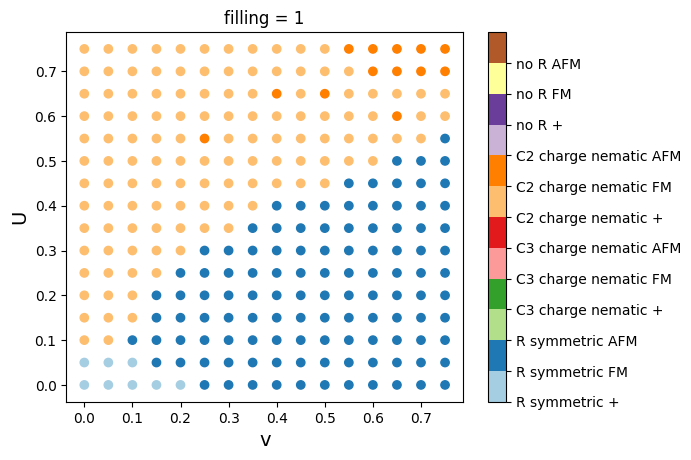

In [10]:
colorbar_ticks_combined = np.arange(len(phase_list_final))
cmap = plt.get_cmap("Paired", len(phase_list_final))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(u_mesh, v1_mesh, c=phase_diagram_based_on_d, cmap=cmap,vmin=0, vmax=len(phase_list_final))
# plt.xlabel(r'$E_{f}$', size = '14')
plt.xlabel('v', size = '14')
plt.ylabel('U', size = '14')
# plt.xlim(3.8,6)
colorbar_ticks = np.arange(len(phase_list_final))
cbar = plt.colorbar()
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels(phase_list_final)
plt.title('filling = 1')

In [11]:
unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_list_final[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1')

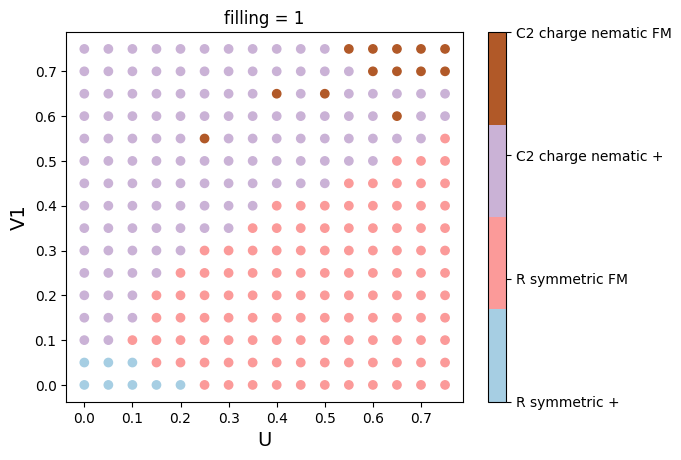

In [12]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(u_mesh, v1_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('U', size = '14')
plt.ylabel('V1', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

Text(0.5, 1.0, 'filling = 1')

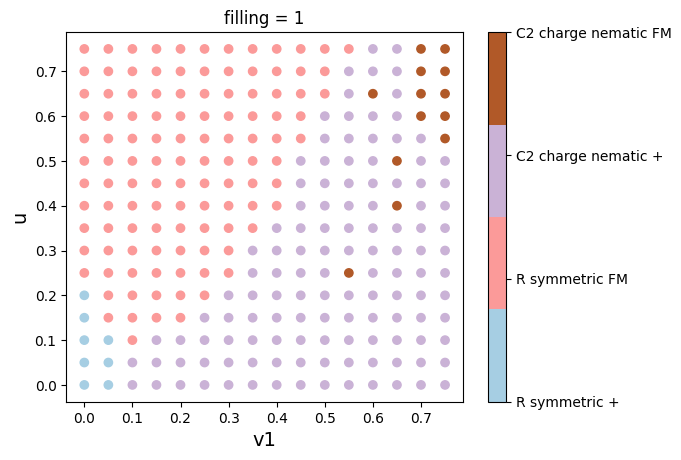

In [13]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(v1_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

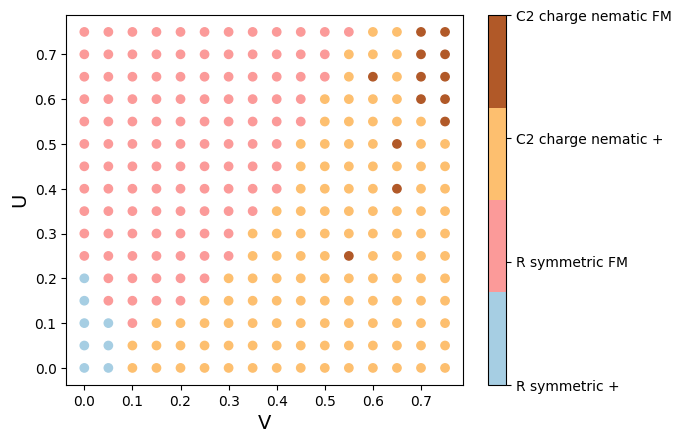

In [15]:
from matplotlib.colors import ListedColormap

paired = plt.get_cmap("Paired").colors
corlor_index = [0,4,6,11]
color_list = [paired[i] for i in corlor_index]

cmap = ListedColormap(color_list)
plt.scatter(v1_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)

### Indeed many scattering points have been smoothened. But some still remained, I guess we can still try harder in the seeding part?

In [ ]:
sorted_ground_state_e[5, -5]

array([-0.13421108, -0.1342079 , -0.1342079 , -0.1342079 , -0.1342079 ,
       -0.1342079 , -0.1342079 , -0.07730499, -0.07730498, -0.07557777])

In [ ]:
sorted_ground_state_e.shape

(16, 16, 10)

In [ ]:
sorted_density[5, -5, 0]

array([[0.16689688+9.91869042e-28j, 0.30302073-1.68542737e-19j,
        0.02905056-3.00086044e-20j],
       [0.16761495-5.04077348e-27j, 0.30409342-3.10125071e-20j,
        0.02932346-3.77361655e-21j]])

In [ ]:
sorted_density[5,-5,1]

array([[0.30586028+4.44338972e-26j, 0.03027358+6.80623112e-21j,
        0.16386615+7.93244153e-20j],
       [0.30586028+1.42784679e-26j, 0.03027358-1.96796127e-20j,
        0.16386615+1.02992316e-19j]])

In [ ]:
sorted_ground_state_e[5, -4]

array([-0.16053037, -0.16053037, -0.16053037, -0.16053037, -0.16053037,
       -0.16053037, -0.16053033, -0.16053032, -0.08588421, -0.08342121])

In [ ]:
sorted_density[5,-4,0]

array([[0.13546607-7.48468637e-26j, 0.03673797+1.06034447e-20j,
        0.32779596+1.01403173e-19j],
       [0.13546607+3.31423038e-25j, 0.03673797-5.29660597e-21j,
        0.32779596+1.51184474e-19j]])

In [ ]:
sorted_density[5,-4,7]

array([[0.13546659-2.54790428e-27j, 0.32779564-1.28710863e-19j,
        0.03673777-1.04005570e-20j],
       [0.13546659-1.14920980e-26j, 0.32779564-3.90533977e-20j,
        0.03673777+1.78955157e-20j]])

In [ ]:
sorted_ground_state_e[8,-3]

array([-0.18214442, -0.18214398, -0.18214398, -0.18214398, -0.18214398,
       -0.18214386, -0.18214386, -0.1806285 , -0.10711802, -0.10376465])

In [ ]:
sorted_density

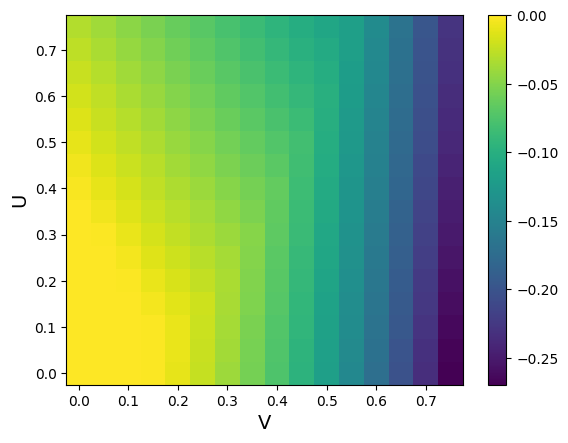

In [ ]:
plt.pcolormesh(v1_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

Text(0.5, 1.0, 'ground state c_6_diff')

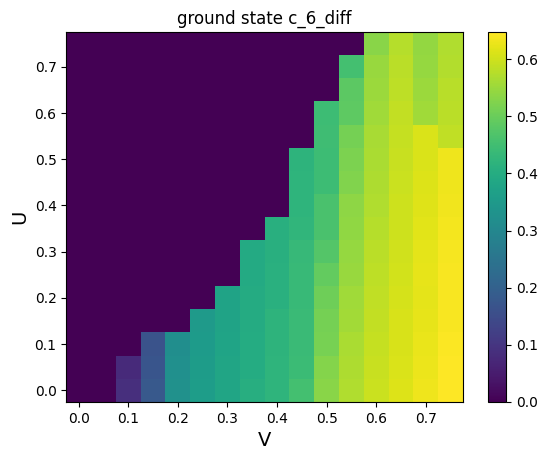

In [ ]:
plt.pcolormesh(v1_mesh,u_mesh,gs_n)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state c_6_diff')

Text(0.5, 1.0, 'ground state max magnetization')

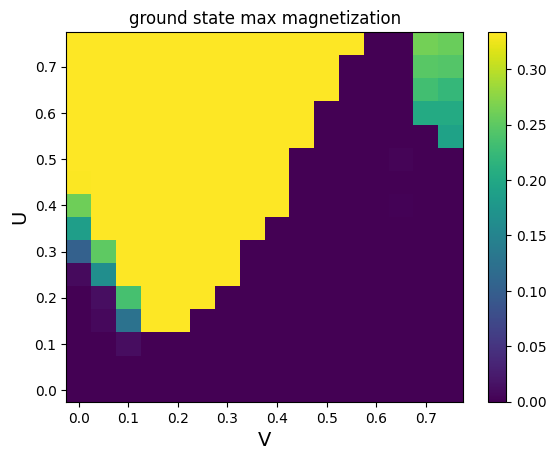

In [ ]:
plt.pcolormesh(v1_mesh,u_mesh,gs_m)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state max magnetization')

In [ ]:
from functions_parameters.jax_schf_helpers import *
from functions_parameters.bond_table_generator import build_buckets_per_shell

basis_frac = np.array([[1/2, 0], [1/2, 1/2], [0, 1/2]])
norb = basis_frac.shape[0]
num_k_mesh = 60
b_0 = np.linspace(-b[0] / 2, b[0] / 2, num_k_mesh, endpoint=False)
b_1 = np.linspace(-b[1] / 2, b[1] / 2, num_k_mesh, endpoint=False)
k_mesh_points = np.vstack([v1 + v2 for v1, v2 in product(b_0, b_1)])
num_k_points = k_mesh_points.shape[0]

radii, a_lists, deltas = build_buckets_per_shell(a, basis_frac, 2)

# in this case, as both TB model and interaction, we include up to NNN, the a_list and deltas are the same
# calculate the correlation matrix
temperature = 4E-4
filling = 1/2
mu = 2
t_nn = 1
t_nnn = -0.025
t_arr = np.array([t_nn, t_nnn])

phase_pos, phase_neg = precompute_k_phase_tables(deltas, a, k_mesh_points)
Htb, e_all, v_all, v_all_dagger = hk_all_k_from_phases(mu, a_lists, t_arr, phase_neg)

nk = e_all.shape[0]
norb = e_all.shape[1]
e_fermi_iterated, ne, converged, iters = fermi_level_bisection_core(e_all, filling, temperature)
electron_count = occ(e_all, e_fermi_iterated, temperature)
# (U @ diag(electron_count) @ U_d).T
corr_k = jnp.einsum('Nni,Ni,Nim->Nmn', v_all, electron_count, v_all_dagger)
# count the spin degeneracy
gs_e = jnp.einsum('Nji, Nji->', Htb, corr_k)/nk*2

# then obtain the mean field decomposition and corresponding 
bond_ref = bond_orders_from_phases(a_lists, corr_k, phase_neg)
bond_ref = np.stack((bond_ref, bond_ref), axis=1)

bond_difference = final_bond[:,:,0] - bond_ref[np.newaxis,np.newaxis,:]

In [ ]:
bond_difference.shape

(16, 16, 9, 2, 2, 3, 3)

In [ ]:
bond_difference_ij = np.sqrt(np.sum(np.abs(bond_difference), axis=(2,3,4,5,6)))

Text(0.5, 1.0, 'ground state max magnetization')

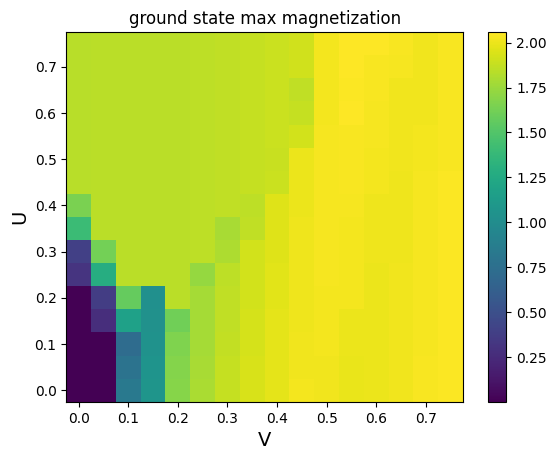

In [ ]:
plt.pcolormesh(v1_mesh,u_mesh,bond_difference_ij)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state max magnetization')

## Select states for next run

In [ ]:
selected_indexes = [(4,-1,0), (5,-5,0), (-5,-3,0), (-5,-2,0), (0,-1,0), (-2,-3,0), (-1,0,0), (-1,-6,0)]

In [ ]:
# first find if there are energy states that are highly degenerate as the known ground state while in the different phase
states_index = np.where(np.logical_and(sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]<1E-4, sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]>1E-7))
# then find out the states that are in a different phase than the known ground state
degenerate_state_diagram = -np.ones((len(states_index[0]),)*3)
for index in states_index:
    i = index[0]
    j = index[1]
    k = index[2]
    d_o = sorted_density[i,j,k]
    rs_recording = np.zeros((4))
    m_recording = np.zeros((4))
    c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_o, c_6, c_3, c_2)
    if c6_diff<threshold:
        rs_recording[0] = 1
    elif c6_diff>threshold and c3_diff<threshold:
        rs_recording[1] = 1
    elif c2_diff<threshold and c6_diff>threshold:
        rs_recording[2] = 1
    else:
        rs_recording[3] = 1
    if np.max(np.abs(magnetism_arr)) > threshold:
        if np.all(magnetism_arr > threshold) or np.all(magnetism_arr < -threshold):
            m_recording[1] = 1
        else:
            net_m = np.sum(magnetism_arr)
            if np.abs(net_m) <= magnetism_arr.size * threshold:
                m_recording[3] = 1
            else:
                m_recording[2] = 1
    else:
        m_recording[0] = 1
    phase_arr = np.kron(rs_recording,m_recording)
    phase = np.where(phase_arr>0.5)[0][0]
    if phase != phase_diagram_based_on_d[i,j]:
        degenerate_state_diagram[i,j,k]=phase


In [ ]:
degenerate_index = np.where(degenerate_state_diagram>0)

In [ ]:
phase_list_final[np.int32(degenerate_state_diagram[6,7,8])]

'no R AFM'

In [ ]:
selected_indexes.append(degenerate_index)

In [ ]:
selected_indexes.append((4,-1,0))